In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import datacube

import numpy as np
from scipy import stats
import xarray as xr

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_plotting import display_map, rgb
from deafrica_bandindices import calculate_indices

In [2]:
dc = datacube.Datacube(app="Vegetation_exercise")

In [3]:
# Define the area of interest
latitude = 0.02
longitude = 35.425
buffer = 0.1

# Combine central lat,lon with buffer to get area of interest
lat_range = (latitude-buffer, latitude+buffer)
lon_range = (longitude-buffer, longitude+buffer)

# Set the range of dates for the complete sample
time = ('2013-01-01', '2018-12-01')

# Set the date to separate the data into two samples for comparison
time_baseline = '2015-12-31'

In [4]:
display_map(x=lon_range, y=lat_range)

In [18]:
landsat_ds = load_ard(
    dc=dc,
    products=["ls8_usgs_sr_scene"],
    lat=lat_range,
    lon=lon_range,
    time=time,
    output_crs="EPSG:6933",
    resolution=(-30, 30),
    align=(15, 15),
    group_by='solar_day',
    measurements=['nir', 'red', 'blue', 'green'],
    min_gooddata=0.7)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 46 out of 213 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 46 time steps


In [ ]:
#what is this?
#landsat_ds

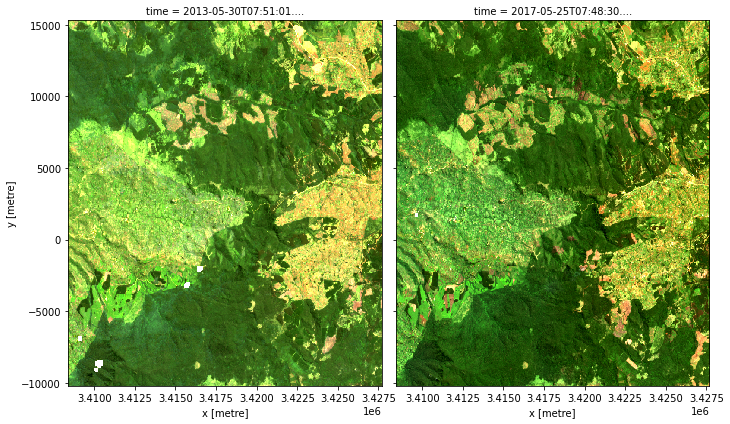

In [24]:
# Set the timesteps to visualise
initial_timestep = 2
final_timestep = 37

rgb(landsat_ds, index=[initial_timestep, final_timestep])

In [51]:
#from the training
#landsat_ds = calculate_indices(landsat_ds, index='EVI', collection='c1')

In [21]:
#from the Vegetation_change_detection.ipynb
# Calculate EVI and add it to the loaded dataset
ds = calculate_indices(landsat_ds, 'EVI', collection='c1')
ds_index = ds.EVI

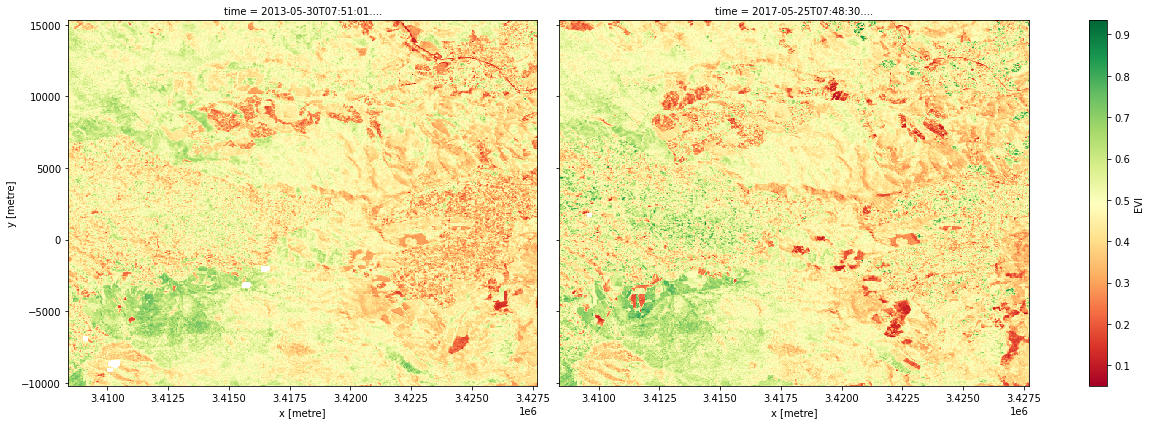

In [22]:
#from the Vegetation_change_detection.ipynb
# Plot the EVI values for pixels classified as vegetation for the two dates
ds_index.isel(time=[initial_timestep, final_timestep]).plot.imshow(
    'x', 'y', col='time', cmap='RdYlGn', figsize=(18, 6)
)

plt.show()

In [ ]:
##lets do further

In [52]:
#from the training
#baseline_sample = landsat_ds.EVI.sel(time=slice(time[0], time_baseline))
#postbaseline_sample = landsat_ds.EVI.sel(time=slice(time_baseline, time[1]))

#baseline_composite = baseline_sample.mean('time')
#postbaseline_composite = postbaseline_sample.mean('time')

In [40]:
#from the Vegetation_change_detection.ipynb
# Make samples
baseline_sample = ds_index.sel(time=slice(time[0], time_baseline))
baseline_composite = ds.sel(time=slice(time[0], time_baseline)).mean('time')
print(f"Number of observations in baseline sample: {len(baseline_sample.time)}")

postbaseline_sample = ds_index.sel(time=slice(time_baseline, time[1]))
postbaseline_composite = ds.sel(time=slice(time_baseline, time[1])).mean('time')
print(f"Number of observations in postbaseline sample: {len(postbaseline_sample.time)}")

# Record coodrinates for reconstructing xarray objects
sample_lat_coords = ds.coords['y']
sample_lon_coords = ds.coords['x']

Number of observations in baseline sample: 23
Number of observations in postbaseline sample: 23


In [53]:
#from the training
#diff_mean_composites = postbaseline_composite - baseline_composite

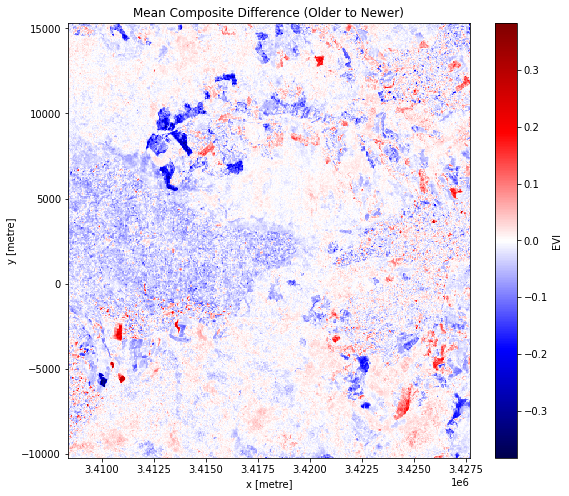

In [54]:
#from the training
#plt.figure(figsize=(9, 8))
#diff_mean_composites.plot.imshow(cmap='seismic')
#plt.title("Mean Composite Difference (Older to Newer)")
#plt.show()

In [ ]:
#go further

In [43]:
#from the Vegetation_change_detection.ipynb
# Perform the t-test on the postbaseline and baseline samples
tstat, p_tstat = stats.ttest_ind(
    postbaseline_sample.values,
    baseline_sample.values,
    equal_var=False,
    nan_policy='omit',
)

# Convert results to an xarray for further analysis
t_test = xr.Dataset(
    {'t_stat': (['y', 'x'], tstat),
     'p_val': (['y', 'x'], p_tstat)},
    coords={
     'x': (['x'], sample_lon_coords.values),
     'y': (['y'], sample_lat_coords.values)
    }, attrs={'crs': ds.crs})

print(t_test)

<xarray.Dataset>
Dimensions:  (x: 644, y: 851)
Coordinates:
  * x        (x) float64 3.408e+06 3.408e+06 3.408e+06 ... 3.428e+06 3.428e+06
  * y        (y) float64 1.53e+04 1.527e+04 1.524e+04 ... -1.017e+04 -1.02e+04
Data variables:
    t_stat   (y, x) float64 -1.184 -0.1697 -0.9949 ... -1.422 -0.9851 -3.141
    p_val    (y, x) float64 0.2434 0.8661 0.3256 ... 0.1642 0.3331 0.003418
Attributes:
    crs:      EPSG:6933


In [44]:
#from the Vegetation_change_detection.ipynb
# Set the significance level
sig_level = 0.01

# Identify any difference in the mean
diff_mean = postbaseline_sample.mean(
    dim=['time']) - baseline_sample.mean(dim=['time'])
diff_mean.name = f"{baseline_sample.name} Difference"

# Identify any difference in the mean classified as significant
sig_diff_mean = postbaseline_sample.mean(dim=['time']).where(
    t_test.p_val < sig_level) - baseline_sample.mean(dim=['time']).where(t_test.p_val < sig_level)
sig_diff_mean.name = f"{baseline_sample.name} Difference"

# Determine areas with significant negative difference
sig_deforestation = sig_diff_mean < 0
sig_deforestation.name = "Negative Change"

# Determine areas with significant positive difference
sig_afforestation = sig_diff_mean > 0
sig_afforestation.name = "Positive Change"

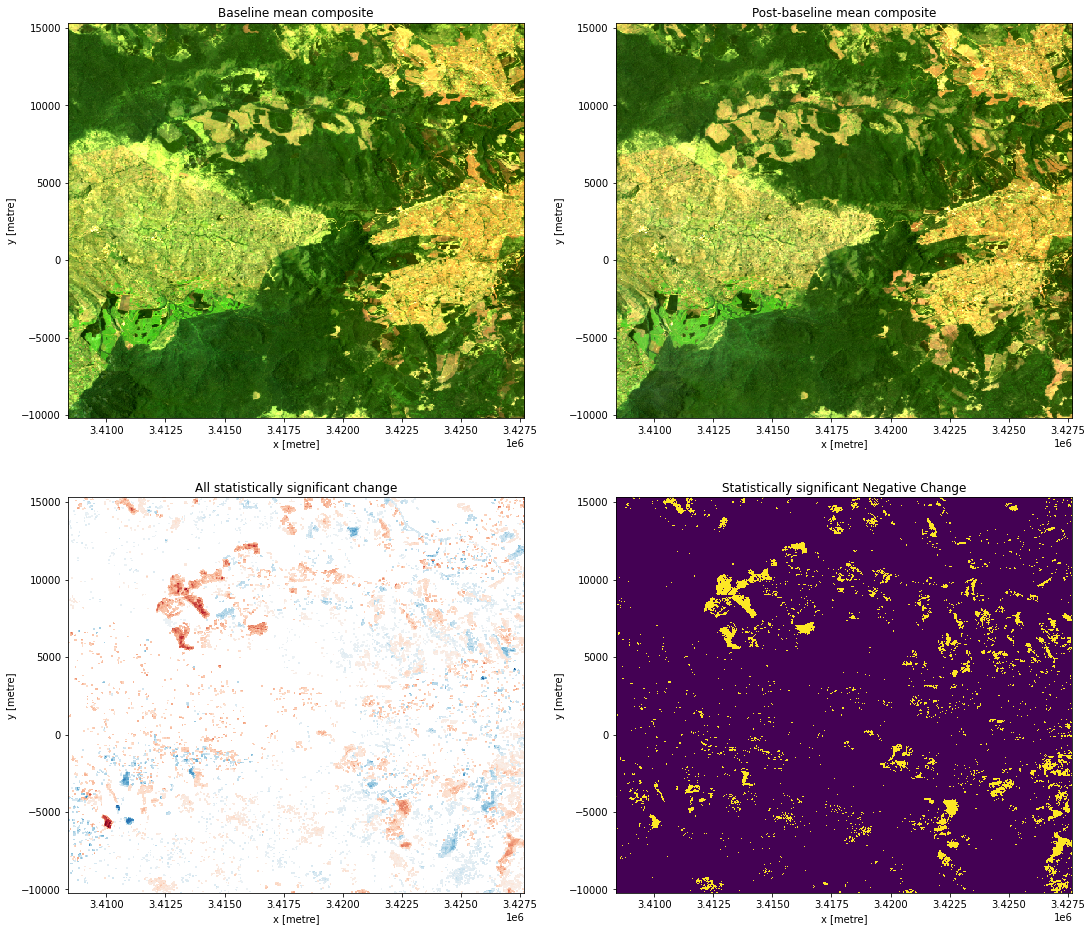

In [45]:
#from the Vegetation_change_detection.ipynb
# Construct the comparison plot
fig, ax = plt.subplots(2, 2, figsize=(18, 16))
baseline_composite[['red', 'green', 'blue']].to_array().plot.imshow(ax=ax[0,0], robust=True)
postbaseline_composite[['red', 'green', 'blue']].to_array().plot.imshow(ax=ax[0,1], robust=True)
sig_diff_mean.plot(cmap='RdBu', ax=ax[1,0], add_colorbar=False)
sig_deforestation.plot(ax=ax[1,1], add_colorbar=False)
ax[0,0].set_title('Baseline mean composite')
ax[0,1].set_title('Post-baseline mean composite')
ax[1,0].set_title('All statistically significant change')
ax[1,1].set_title('Statistically significant Negative Change')
plt.show()

In [46]:
#from the Vegetation_change_detection.ipynb
total_pixels = postbaseline_sample.mean(dim=['time']).count(dim=['x', 'y']).values
total_sig_change = sig_diff_mean.count(dim=['x', 'y']).values
total_deforestation = sig_deforestation.where(sig_deforestation==True).count(dim=['x', 'y']).values

percentage_sig_change = (total_sig_change/total_pixels)*100
percentage_deforestation = (total_deforestation/total_pixels)*100

print(f"{percentage_sig_change:.2f}% of pixels that likely underwent significant change in any direction")
print(f"{percentage_deforestation:.2f}% of pixels that likely underwent negative change")

8.05% of pixels that likely underwent significant change in any direction
5.42% of pixels that likely underwent negative change


In [ ]:
#from the Vegetation_change_detection.ipynb
#export
write_cog(diff_mean, 
          fname="ttest_diff_mean.tif", 
          overwrite=True)

write_cog(sig_diff_mean, 
          fname="ttest_sig_diff_mean.tif", 
          overwrite=True)